# Predicting Bike Rental Count

-  The objective of this Case is Predication of bike rental count on daily based on the environmental and seasonal settings

In [336]:
# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from fancyimpute import KNN
from scipy.stats import chi2_contingency
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics

In [337]:
# set the working directory
os.chdir('C:/Users/admin/Documents/Python Files')
os.getcwd()

'C:\\Users\\admin\\Documents\\Python Files'

The details of data attributes in the dataset are as follows:
-  instant: Record index
-  dteday: Date
-  season: Season (1:springer, 2:summer, 3:fall, 4:winter)
-  yr: Year (0: 2011, 1:2012)
-  mnth: Month (1 to 12)
-  holiday: weather day is holiday or not (extracted fromHoliday Schedule)
-  weekday: Day of the week
-  workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
-  weathersit: (extracted fromFreemeteo)
    -   1: Clear, Few clouds, Partly cloudy, Partly cloudy
    -   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    -   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scatteredclouds
    -   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
-  temp: Normalized temperature in Celsius. The values are derived via(t-t_min)/(t_max-t_min),t_min=-8, t_max=+39 (only in hourly scale)
-  atemp: Normalized feeling temperature in Celsius. The values are derived via(t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
-  hum: Normalized humidity. The values are divided to 100 (max)
-  windspeed: Normalized wind speed. The values are divided to 67 (max)
-  casual: count of casual users
-  registered: count of registered users
-  cnt: count of total rental bikes including both casual and registered

In [338]:
# Importing data
df = pd.read_csv('day.csv',index_col='dteday',parse_dates=True,infer_datetime_format=True,dayfirst=True)
# Dropping the 1st column i.e. 'instant' Coz it is seems statisticaly insignificant
df=df.drop('instant',axis=1)
df.head(5)

season  yr  mnth  holiday  weekday  workingday  weathersit  \
dteday                                                                   
2011-01-01       1   0     1        0        6           0           2   
2011-01-02       1   0     1        0        0           0           2   
2011-01-03       1   0     1        0        1           1           1   
2011-01-04       1   0     1        0        2           1           1   
2011-01-05       1   0     1        0        3           1           1   

                temp     atemp       hum  windspeed  casual  registered   cnt  
dteday                                                                         
2011-01-01  0.344167  0.363625  0.805833   0.160446     331         654   985  
2011-01-02  0.363478  0.353739  0.696087   0.248539     131         670   801  
2011-01-03  0.196364  0.189405  0.437273   0.248309     120        1229  1349  
2011-01-04  0.200000  0.212122  0.590435   0.160296     108        1454  1562  
2011-01-05  0.226957  0.229270  0.436957   0.186900      82        1518  1600

In [339]:
df.describe(),df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(10)
memory usage: 85.7 KB


(           season          yr        mnth     holiday     weekday  workingday  \
 count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
 mean     2.496580    0.500684    6.519836    0.028728    2.997264    0.683995   
 std      1.110807    0.500342    3.451913    0.167155    2.004787    0.465233   
 min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
 25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
 50%      3.000000    1.000000    7.000000    0.000000    3.000000    1.000000   
 75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
 max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   
 
        weathersit        temp       atemp         hum   windspeed  \
 count  731.000000  731.000000  731.000000  731.000000  731.000000   
 mean     1.395349    0.495385    0.474354    0.627894    0.190486   
 std      0.544894    0.183051    0.162961    0.14

-  We have used dteday as index and converted it into DatetimeIndex 

In [340]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Graphical EDA - Data Visualization 

In [341]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

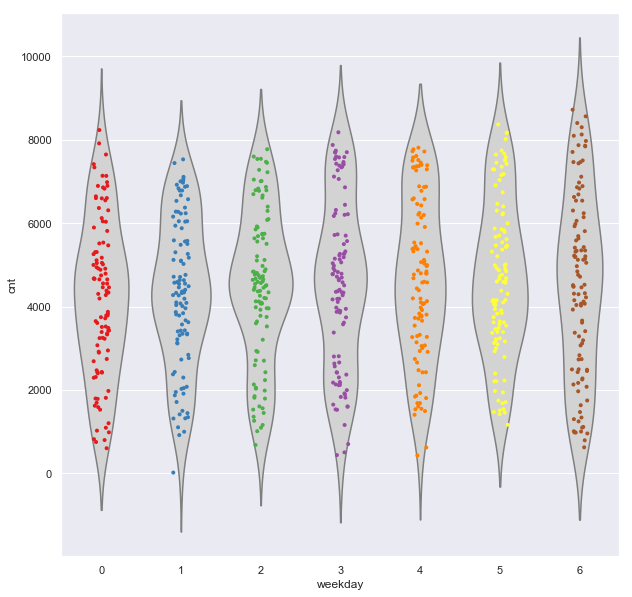

In [342]:
plt.figure(figsize=(10,10))
_ = sns.violinplot(x='weekday',y='cnt',data=df,inner=None,color='lightgray')
_ = sns.stripplot(x='weekday',y='cnt',data=df,size=4,jitter=True)
plt.title('')
plt.show()

-  We will plot some Bee Swarmplots coz unlike histogram there is no binnig bias involved

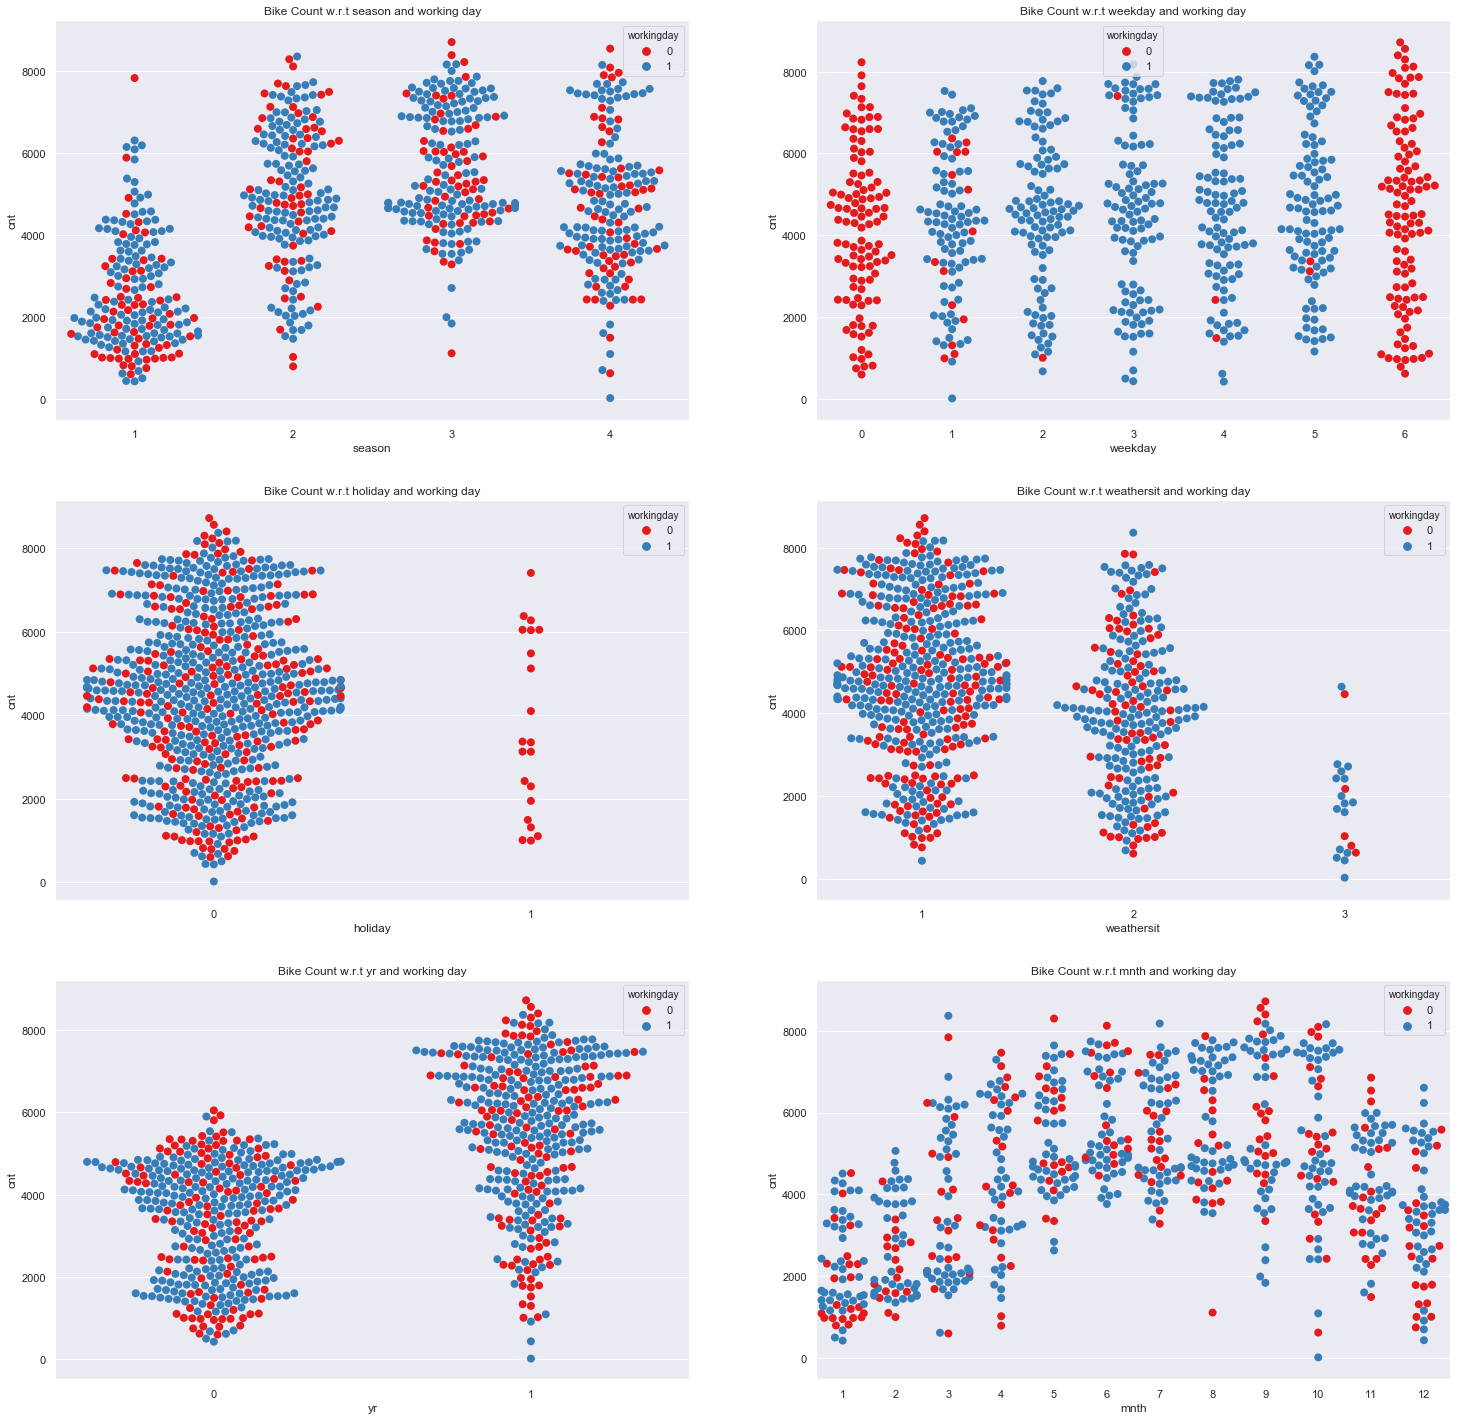

In [343]:
plt.figure(figsize=(25,25))
plt.subplot(321)
_ = sns.swarmplot(x='season',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t season and working day')
plt.subplot(322)
_ = sns.swarmplot(x='weekday',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t weekday and working day')
plt.subplot(323)
_ = sns.swarmplot(x='holiday',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t holiday and working day')
plt.subplot(324)
_ = sns.swarmplot(x='weathersit',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t weathersit and working day')
plt.subplot(325)
_ = sns.swarmplot(x='yr',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t yr and working day')
plt.subplot(326)
_ = sns.swarmplot(x='mnth',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t mnth and working day')
# plt.savefig('Bee Swarmplots.png')
plt.show()

In [344]:
temp = df['temp']
temp=temp['2011']
atemp = df['atemp']
atemp = atemp['2011']
hum = df['hum']
hum = hum['2011']
windspeed = df['windspeed']
windspeed = windspeed['2011']
temp_index = temp.index[::30]
labels = temp_index.strftime('%b %d')
labels

Index(['Jan 01', 'Jan 31', 'Mar 02', 'Apr 01', 'May 01', 'May 31', 'Jun 30',
       'Jul 30', 'Aug 29', 'Sep 28', 'Oct 28', 'Nov 27', 'Dec 27'],
      dtype='object')

-  Now we will do some Time Series Analysis

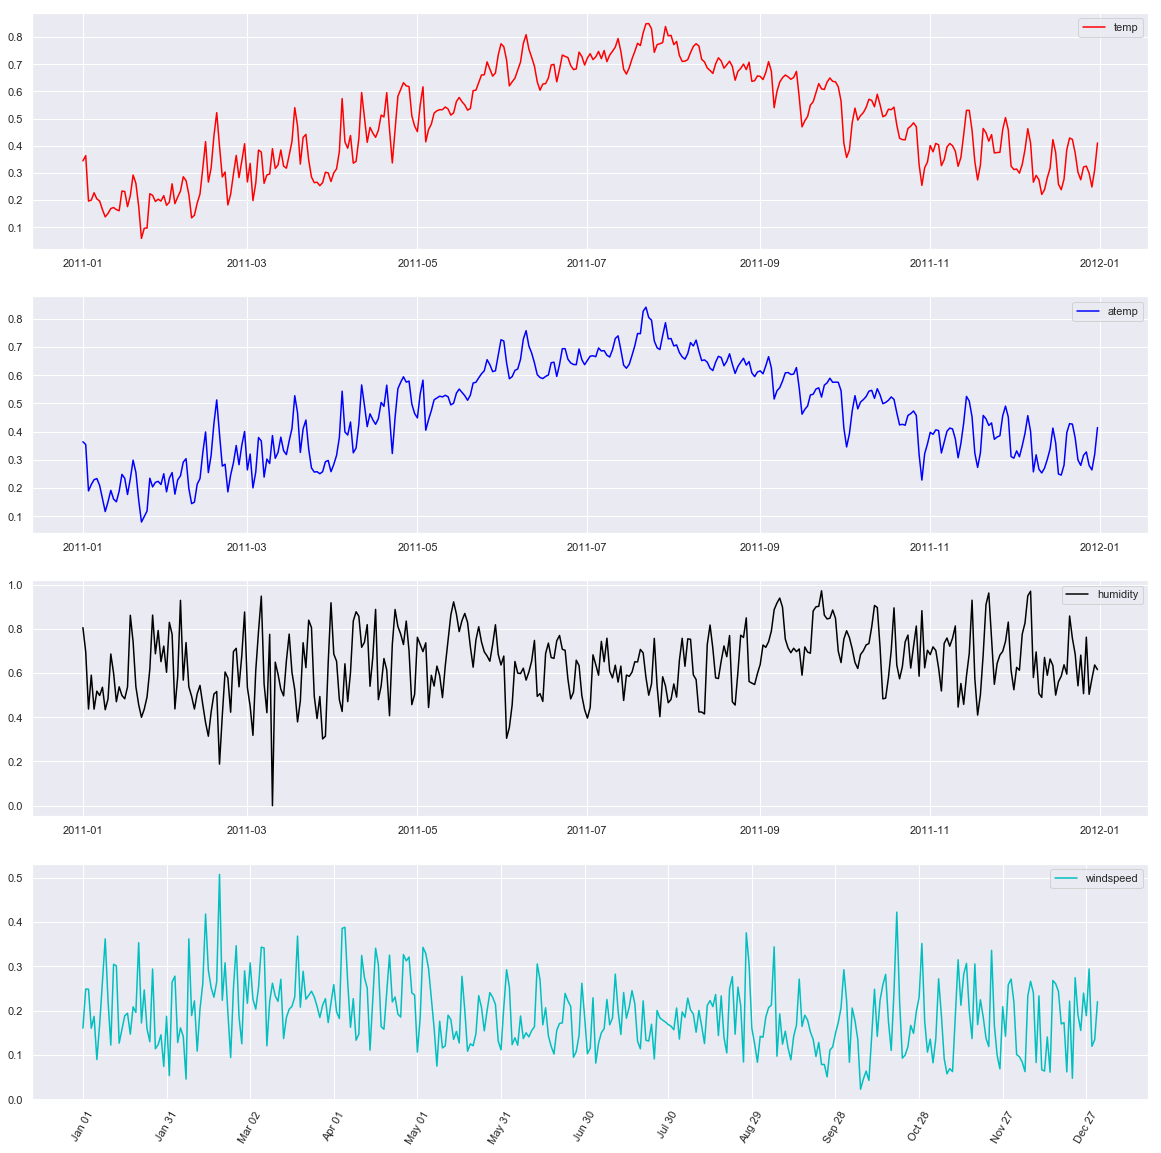

In [345]:
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(temp,color = 'r',label = 'temp')
plt.legend(loc = 1)
plt.subplot(412)
plt.plot(atemp,color = 'b',label = 'atemp')
plt.legend(loc = 1)
plt.subplot(413)
plt.plot(hum,color = 'k',label = 'humidity')
plt.legend(loc = 1)
plt.subplot(414)
plt.plot(windspeed,color = 'c',label = 'windspeed')
plt.xticks(temp_index,labels,rotation=60)
plt.legend(loc = 1)
# plt.savefig('Time.png')
plt.show()

-  Now we will see at some Jointplots.
-  They are used for Bivariate Analysis.
-  Here we have plotted Scatter plot with Regression line between 2 variables along with separate Bar plots of both variables.
-  Also we have annotated pearson correlation coefficient and p value.

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


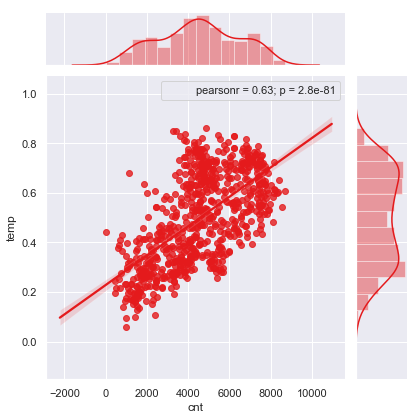

In [346]:
_ = sns.jointplot(x='cnt',y='temp',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


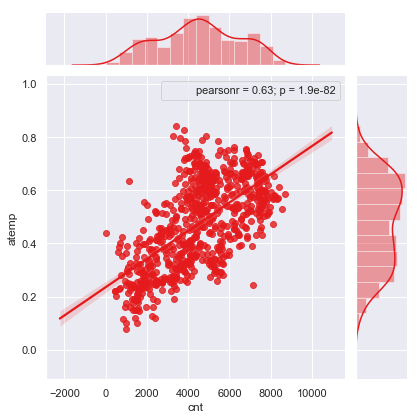

In [347]:
_ = sns.jointplot(x='cnt',y='atemp',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointcat.png')
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


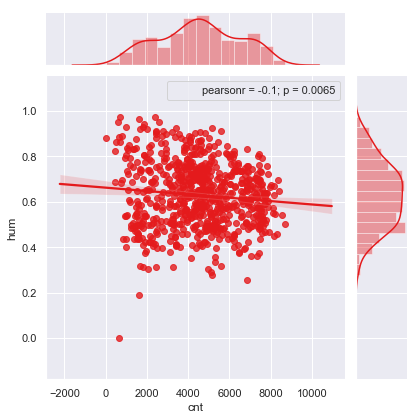

In [348]:
_ = sns.jointplot(x='cnt',y='hum',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointch.png')
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


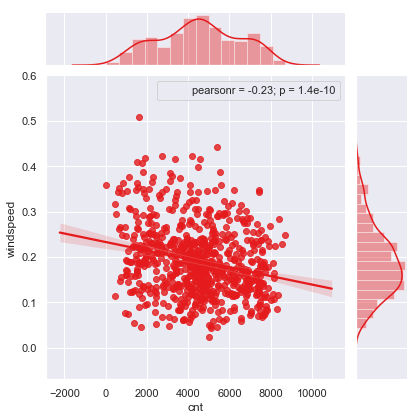

In [349]:
_ = sns.jointplot(x='cnt',y='windspeed',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointcw.png')
plt.show()

## EDA - Data type conversion

In [423]:
cat_var=['season','holiday','weekday','workingday','weathersit','yr','mnth']
df[cat_var]=df[cat_var].apply(lambda x: x.astype('category') )
num_var=['temp','atemp','hum','windspeed']

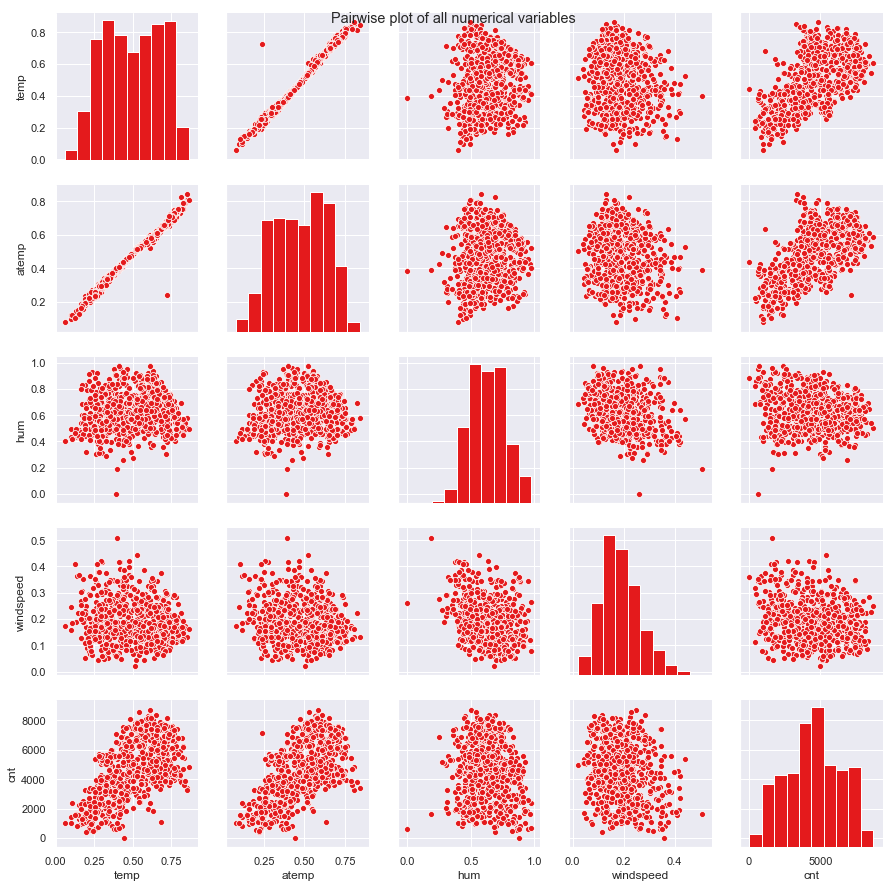

In [351]:
#Pairplot for all numerical variables
_ =sns.pairplot(data=df[num_var],kind='scatter')
_.fig.suptitle('Pairwise plot of all numerical variables')
# plt.savefig('Pairwise.png')
plt.show()

## Missing Value Analysis 

In [352]:
pd.DataFrame(df.isnull().sum())

0
season      0
yr          0
mnth        0
holiday     0
weekday     0
workingday  0
weathersit  0
temp        0
atemp       0
hum         0
windspeed   0
casual      0
registered  0
cnt         0

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
season        731 non-null category
yr            731 non-null category
mnth          731 non-null category
holiday       731 non-null category
weekday       731 non-null category
workingday    731 non-null category
weathersit    731 non-null category
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: category(7), float64(4), int64(3)
memory usage: 72.0 KB


## Outlier Analysis using Boxplot

-  Univariate Boxplots: Boxplots for all Numerical Variables also for target variable.

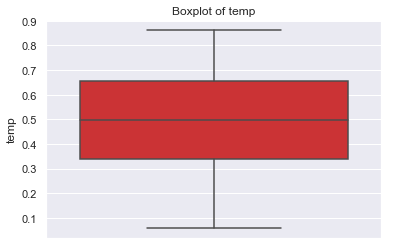

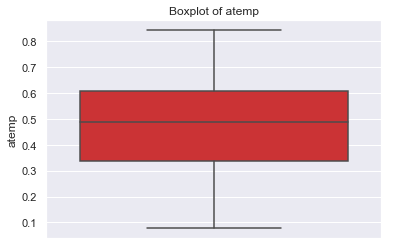

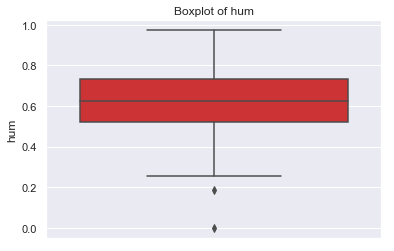

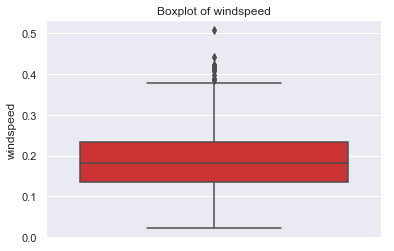

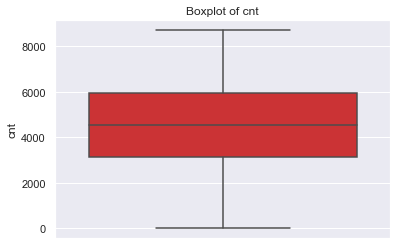

In [354]:
for i in num_var:
    sns.boxplot(y=i,data=df)
    plt.title('Boxplot of '+i)
#     plt.savefig('bp'+str(i)+'.png')
    plt.show()

-  Bivariate Boxplots: Boxplots for all Numerical Variables Vs all Categorical Variables

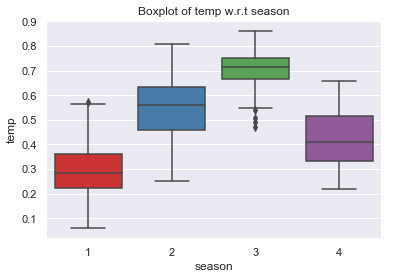

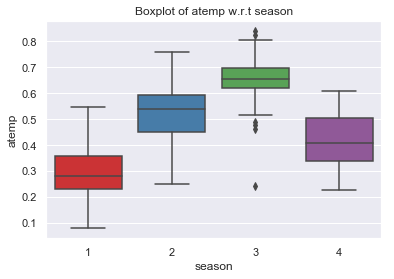

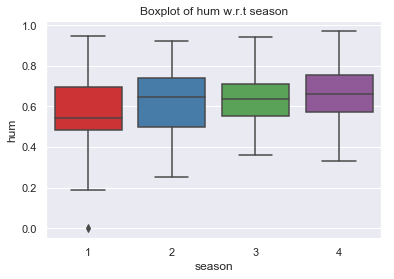

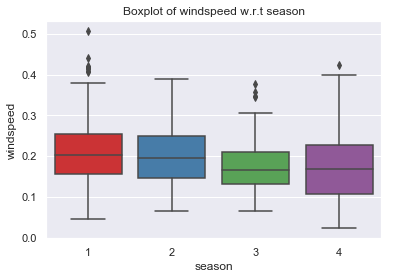

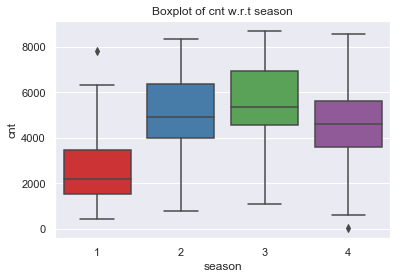

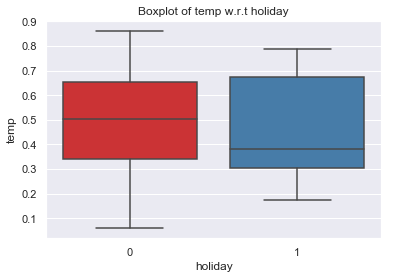

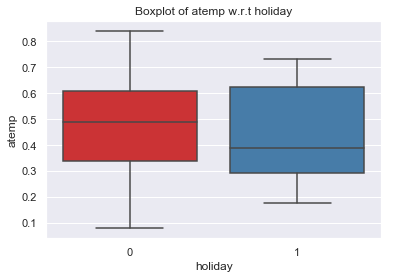

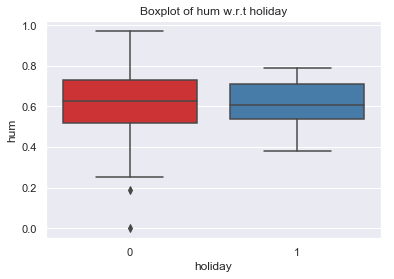

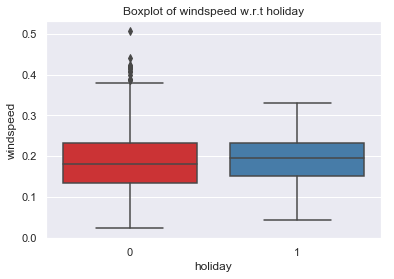

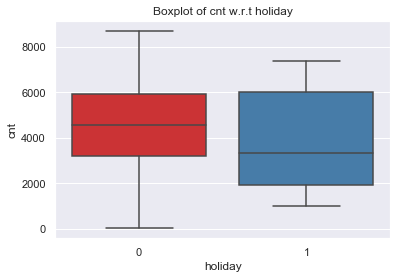

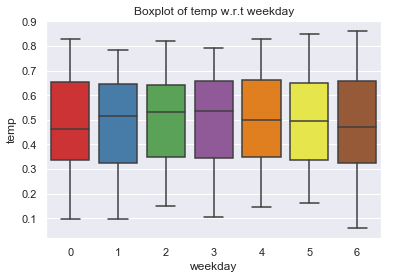

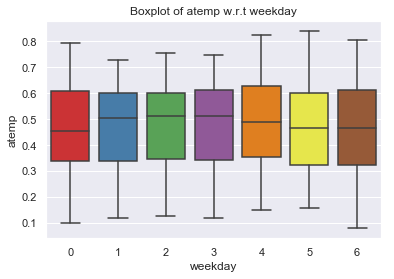

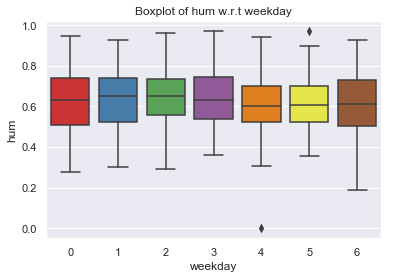

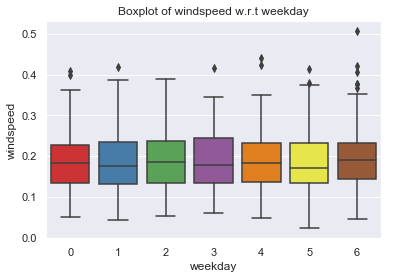

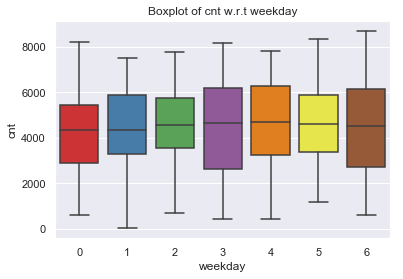

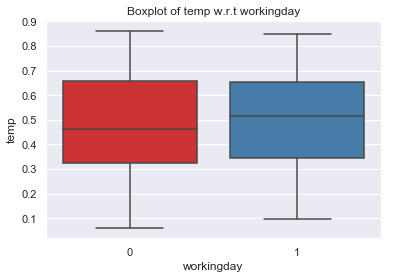

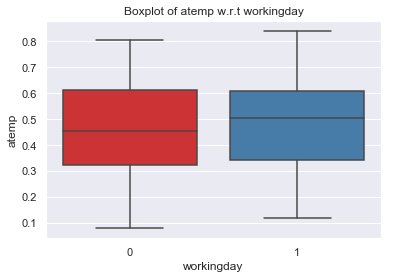

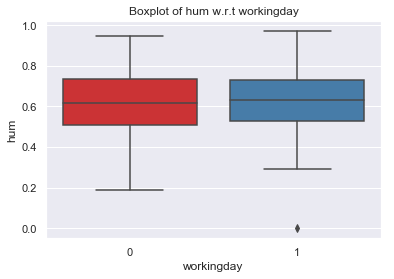

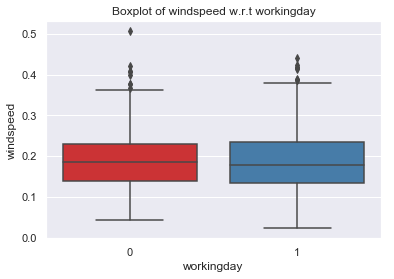

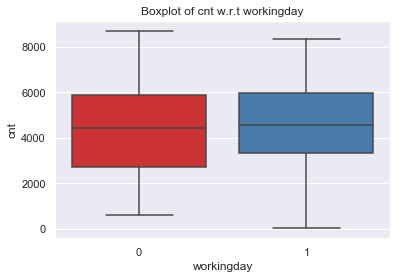

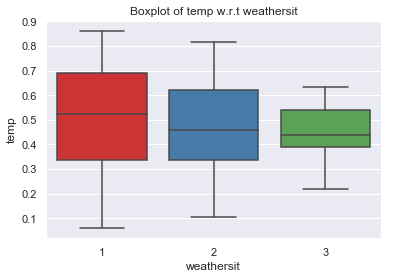

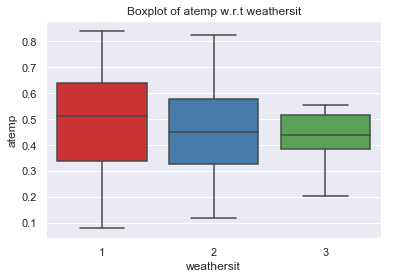

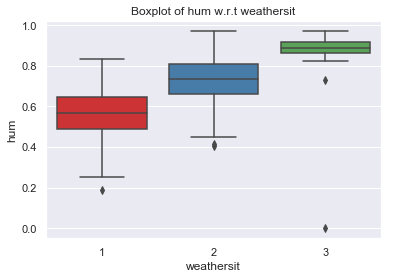

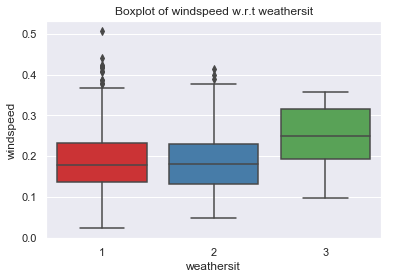

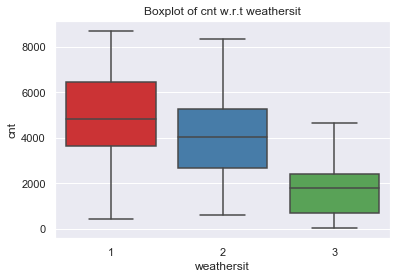

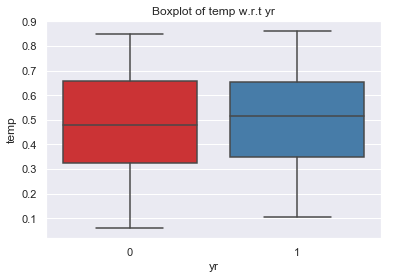

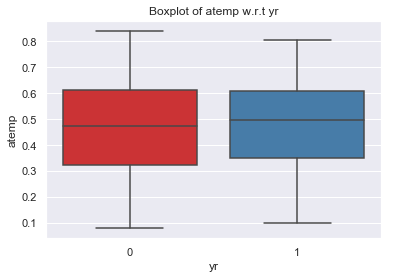

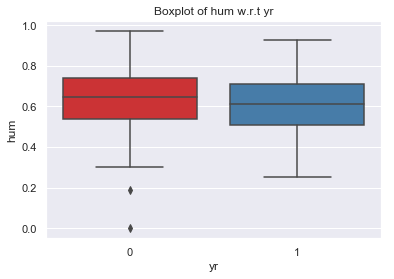

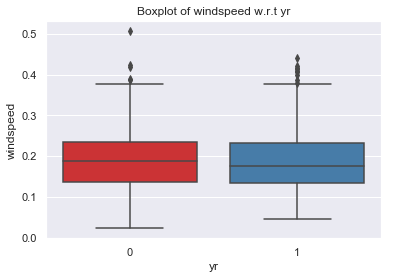

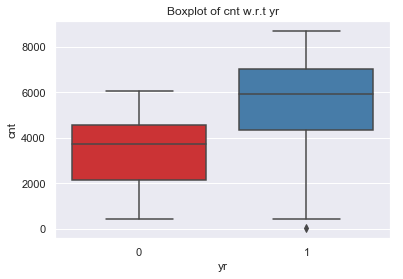

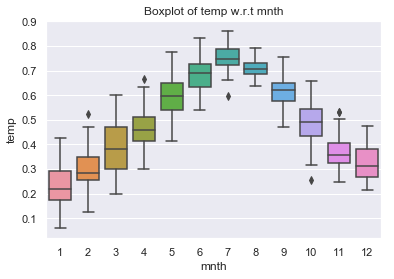

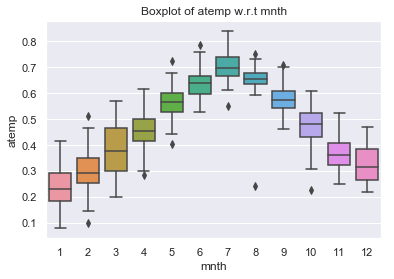

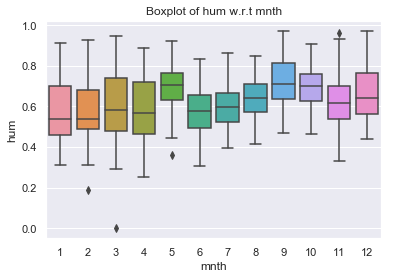

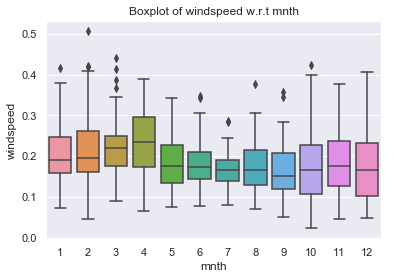

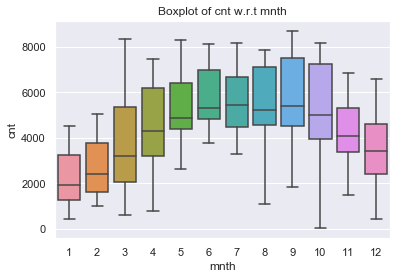

In [355]:
for a in cat_var:
    for b in num_var:
        _ = sns.boxplot(x=a,y=b,data=df)
        plt.title('Boxplot of '+b+' w.r.t '+a)
#         plt.savefig('Boxplot of '+str(b)+' w.r.t '+str(a)+'.png')
        plt.show()

## Outlier Treatment
-  As we can see from the above Boxplots only 'hum' and 'windspeed' columns in the dataset has outliers

In [356]:
df.std()

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.142429
windspeed        0.077498
casual         686.622488
registered    1560.256377
cnt           1937.211452
dtype: float64

#### Std Deviation before outlier treatment :
-  standard deviation for 'hum'= 0.142429
-  standard deviation for 'windspeed'= 0.077498

In [357]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(df[col], [75 ,25])
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    #Replace with NA
    df.loc[df[col] < minimum,col] = np.nan
    df.loc[df[col] > maximum,col] = np.nan

In [358]:
outlier_treatment('hum')

In [359]:
df['hum'].isnull().sum()

2

-  We have checked standard deviation for 3 imputation methods-mean,median,KNN and standard deviation remains nearly same with KNN imputation. so, KNN is selected for imputation method.
-  And we have also checked standard deviation for different values of K for KNN and we have selected K=3 for 'hum' and K=1 for 'windspeed'.

In [360]:
#Imputing with missing values using KNN
df = pd.DataFrame(KNN(k = 3).fit_transform(df), columns = df.columns, index=df.index)

Imputing row 1/731 with 0 missing, elapsed time: 0.147
Imputing row 101/731 with 0 missing, elapsed time: 0.148
Imputing row 201/731 with 0 missing, elapsed time: 0.149
Imputing row 301/731 with 0 missing, elapsed time: 0.149
Imputing row 401/731 with 0 missing, elapsed time: 0.150
Imputing row 501/731 with 0 missing, elapsed time: 0.150
Imputing row 601/731 with 0 missing, elapsed time: 0.151
Imputing row 701/731 with 0 missing, elapsed time: 0.152


In [361]:
outlier_treatment('windspeed')

In [362]:
df['windspeed'].isnull().sum()

13

In [363]:
#Imputing with missing values using KNN
df = pd.DataFrame(KNN(k = 1).fit_transform(df), columns = df.columns, index=df.index)

Imputing row 1/731 with 0 missing, elapsed time: 0.138
Imputing row 101/731 with 0 missing, elapsed time: 0.139
Imputing row 201/731 with 0 missing, elapsed time: 0.139
Imputing row 301/731 with 0 missing, elapsed time: 0.140
Imputing row 401/731 with 0 missing, elapsed time: 0.141
Imputing row 501/731 with 0 missing, elapsed time: 0.142
Imputing row 601/731 with 0 missing, elapsed time: 0.142
Imputing row 701/731 with 0 missing, elapsed time: 0.143


In [364]:
# #Impute with mean
# df['hum'] = df['hum'].fillna(df['hum'].median())
# #Impute with median
# df['windspeed'] = df['windspeed'].fillna(df['windspeed'].median())

In [365]:
df.std()

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.140021
windspeed        0.071707
casual         686.622488
registered    1560.256377
cnt           1937.211452
dtype: float64

#### Std Deviation after outlier treatment :
-  standard deviation for 'hum'= 0.140021
-  standard deviation for 'windspeed'= 0.071707

In [366]:
df.head()

season   yr  mnth  holiday  weekday  workingday  weathersit  \
dteday                                                                    
2011-01-01     1.0  0.0   1.0      0.0      6.0         0.0         2.0   
2011-01-02     1.0  0.0   1.0      0.0      0.0         0.0         2.0   
2011-01-03     1.0  0.0   1.0      0.0      1.0         1.0         1.0   
2011-01-04     1.0  0.0   1.0      0.0      2.0         1.0         1.0   
2011-01-05     1.0  0.0   1.0      0.0      3.0         1.0         1.0   

                temp     atemp       hum  windspeed  casual  registered  \
dteday                                                                    
2011-01-01  0.344167  0.363625  0.805833   0.160446   331.0       654.0   
2011-01-02  0.363478  0.353739  0.696087   0.248539   131.0       670.0   
2011-01-03  0.196364  0.189405  0.437273   0.248309   120.0      1229.0   
2011-01-04  0.200000  0.212122  0.590435   0.160296   108.0      1454.0   
2011-01-05  0.226957  0.229270  0.436957   0.186900    82.0      1518.0   

               cnt  
dteday              
2011-01-01   985.0  
2011-01-02   801.0  
2011-01-03  1349.0  
2011-01-04  1562.0  
2011-01-05  1600.0

## Feature Selection

### Correlation Analysis for Numerical Variables/Features

-  We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.
-  We go for correlation to avoid redundant information in our model development.

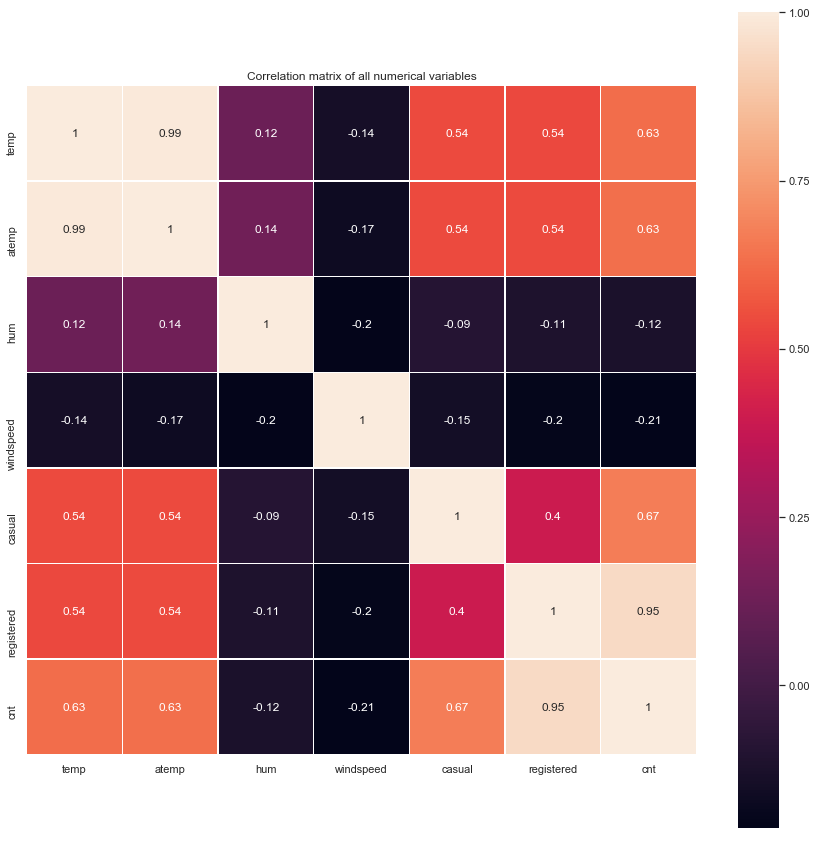

In [367]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(df[['temp','atemp','hum','windspeed','casual', 'registered','cnt']].corr(),linewidths=0.5,linecolor='w',square=True,annot=True)
plt.title('Correlation matrix of all numerical variables')
# plt.savefig('correlation.png')
plt.show()

-  'temp' and 'atemp' are very highly correlated with each other.
-  similarly, 'registered' and 'cnt' are highly correlated with each other.
-  we also came to know that--'cnt'='casual'+'registered'

### Chi-square test of Independence for Categorical Variables/Features

-  Hypothesis testing :
    -  Null Hypothesis: 2 variables are independent.
    -  Alternate Hypothesis: 2 variables are not independent.
-  If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
-  And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 
-  There should be no dependencies between Independent variables.
-  So we will remove that variable whose p-value with other variable is low than 0.05.
-  And we will keep that variable whose p-value with other variable is high than 0.05

In [368]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

season and holiday are independent on each other with 0.6831687073042003 ----Keep
season and weekday are independent on each other with 0.9999999999988407 ----Keep
season and workingday are independent on each other with 0.8865568364019545 ----Keep
season and weathersit are dependent on each other with 0.021179301044733697 ----Remove
season and yr are independent on each other with 0.9999288084245916 ----Keep
season and mnth are dependent on each other with 0.0 ----Remove
holiday and season are independent on each other with 0.6831687073042005 ----Keep
holiday and weekday are dependent on each other with 8.567055344615667e-11 ----Remove
holiday and workingday are dependent on each other with 4.033370935452143e-11 ----Remove
holiday and weathersit are independent on each other with 0.6008572213448835 ----Keep
holiday and yr are independent on each other with 0.9949247279855291 ----Keep
holiday and mnth are independent on each other with 0.5593083086035064 ----Keep
weekday and season are

-  variables which are highly dependent on each other based on p-values are:
    - season and weathersit-0.0211
    - season and month-0
    - holiday and weekday-8.56e-11
    - hoilday and workingday-4.033e-11
    - weekday and holiday-8.56e-11
    - weekday and workingday-6.77e-136
    - workingday and holiday-4.033e-11
    - workingday and weekday-6.77e-11
    - weathersit and season-0.0211
    - weathersit and mnth-0.014
    - mnth and season-0
    - mnth and weathersit-0.014
-  So besides season,holiday and yr we will remove weekday,weathersit,workingday,mnth.

In [422]:
# Back up data
# aj = df
df = aj

In [424]:
df = df.drop(['mnth','weekday','weathersit','workingday'],axis = 1)

## Feature Scaling

-  Let us check variance for each column in dataset before Normalisation
-  High variance will affect the accuracy of the model. so we want to normalise that variance.

In [425]:
df[num_var].var()

temp         0.033508
atemp        0.026556
hum          0.019606
windspeed    0.005142
dtype: float64

Normality Check by Plotting distplot and probplot

-  Distribution before Normaliation

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


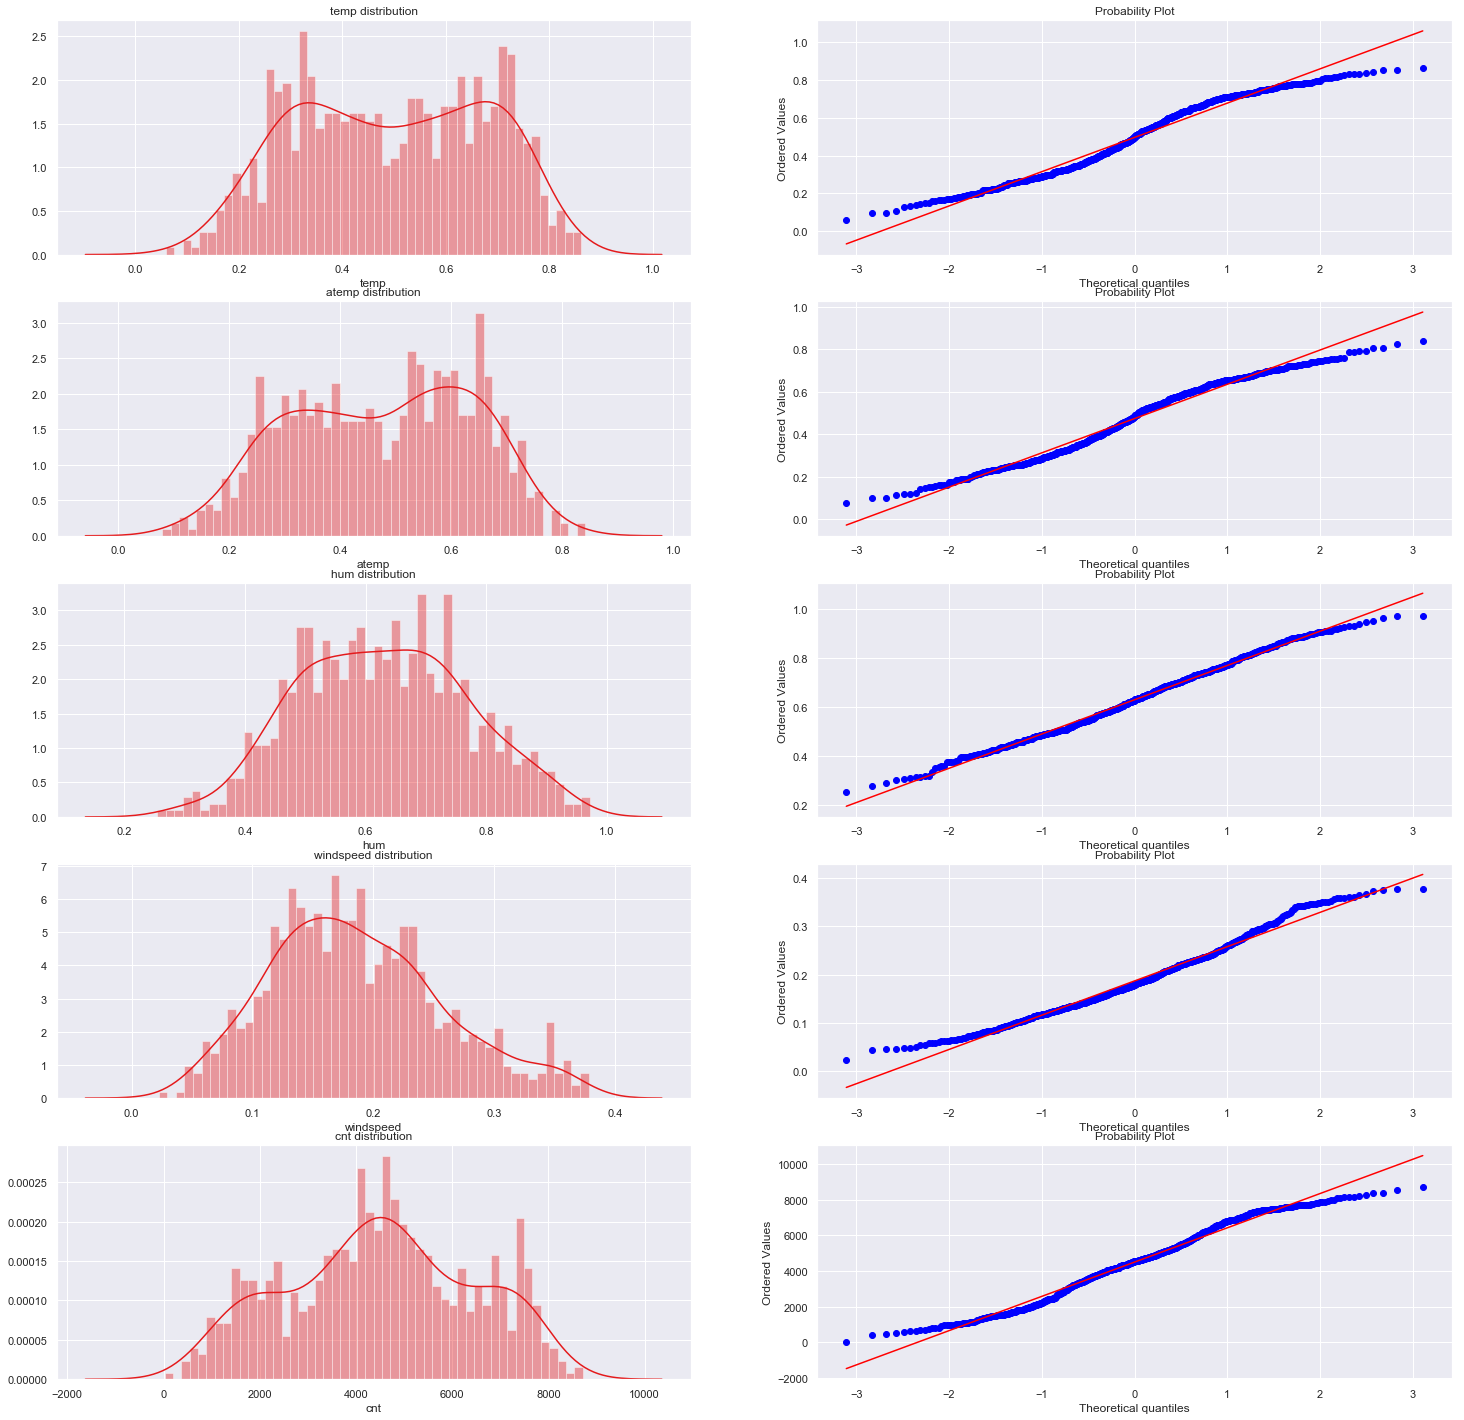

In [426]:
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")
# plt.savefig('Distribution before Normaliation.png')
plt.show()

### Note: If you want to use PCA don't normalise the data use scaler method instead which is in PCA section of code.

In [428]:
#Normalisation
for i in num_var:
    print(i)
    df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))

temp
atemp
hum
windspeed


-  Distribution before Normaliation

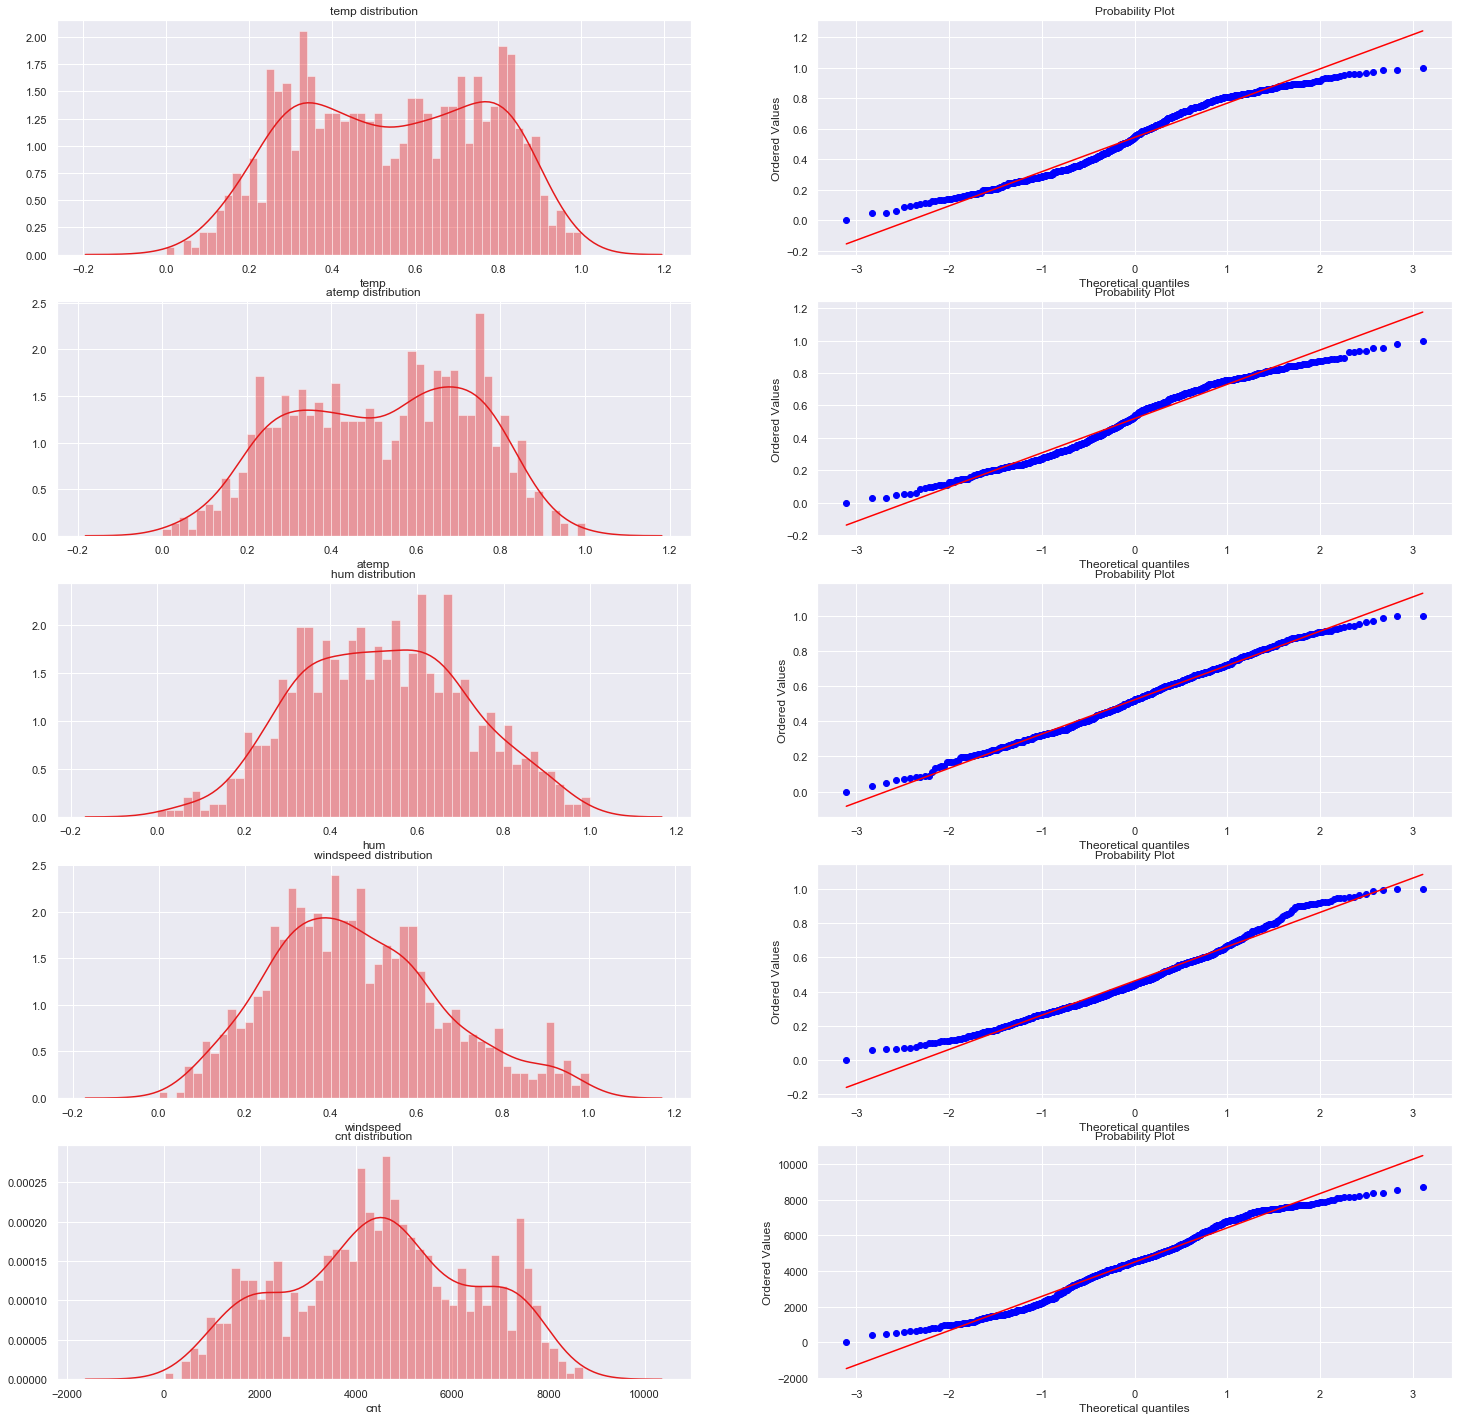

In [429]:
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")
# plt.savefig('Distribution before Normaliation.png')
plt.show()

-  Let us check variance for each column in dataset after Normalisation

In [430]:
df[num_var].var()

temp         0.052025
atemp        0.045757
hum          0.037996
windspeed    0.040636
dtype: float64

## More Feature Selection Test

## Analysis of Variance(Anova) Test

-  It is carried out to compare between each groups in a categorical variable.
-  ANOVA only lets us know the means for different groups are same or not. It doesnâ€™t help us identify which mean is different.
-  Hypothesis testing :
    -  Null Hypothesis: mean of all categories in a variable are same.
    -  Alternate Hypothesis: mean of at least one category in a variable is different.
-  If p-value is less than 0.05 then we reject the null hypothesis.
-  And if p-value is greater than 0.05 then we accept the null hypothesis.

In [376]:
df.head()

season   yr  holiday      temp     atemp       hum  windspeed  \
dteday                                                                      
2011-01-01     1.0  0.0      0.0  0.355170  0.373517  0.767981   0.388102   
2011-01-02     1.0  0.0      0.0  0.379232  0.360541  0.615202   0.635752   
2011-01-03     1.0  0.0      0.0  0.171000  0.144830  0.254904   0.635105   
2011-01-04     1.0  0.0      0.0  0.175530  0.174649  0.468123   0.387681   
2011-01-05     1.0  0.0      0.0  0.209120  0.197158  0.254464   0.462471   

            casual  registered       cnt  
dteday                                    
2011-01-01   331.0       654.0  0.110792  
2011-01-02   131.0       670.0  0.089623  
2011-01-03   120.0      1229.0  0.152669  
2011-01-04   108.0      1454.0  0.177174  
2011-01-05    82.0      1518.0  0.181546

In [431]:
cat_var=['season','holiday','yr']
df[cat_var]=df[cat_var].apply(lambda x: x.astype('category') )
num_var=['temp','atemp','hum','windspeed','cnt']
df[num_var]=df[num_var].apply(lambda x: x.astype('float') )

In [432]:
def anova_test(df,target):
    for i in cat_var:
        formula=('{} ~ {}').format(target, i)
        df.lm = ols(formula,data=df).fit()
        table = sm.stats.anova_lm(df.lm, typ=1)
        print('Anova table between',target,'and',i,'is\n',table)

In [433]:
# print('\n For target var = casual--')
# anova_test(df,'casual')
# print('\n For target var = registered--')
# anova_test(df,'registered')
print('\n For target var = cnt--')
anova_test(df,'cnt')


 For target var = cnt--
Anova table between cnt and season is
              df        sum_sq       mean_sq           F        PR(>F)
season      3.0  9.505959e+08  3.168653e+08  128.769622  6.720391e-67
Residual  727.0  1.788940e+09  2.460715e+06         NaN           NaN
Anova table between cnt and holiday is
              df        sum_sq       mean_sq         F    PR(>F)
holiday     1.0  1.279749e+07  1.279749e+07  3.421441  0.064759
Residual  729.0  2.726738e+09  3.740381e+06       NaN       NaN
Anova table between cnt and yr is
              df        sum_sq       mean_sq           F        PR(>F)
yr          1.0  8.798289e+08  8.798289e+08  344.890586  2.483540e-63
Residual  729.0  1.859706e+09  2.551038e+06         NaN           NaN


-  After looking at above table we see that p-value is greater than 0.05 for weekday and less for season,weathersit,yr.
-  Therefore, we will accept the NULL hypothesis and we can say that some means are nearly/closely same for holiday.
-  and accept alternate hypothsis for season,yr say that some means are not equal.

## Multicollinearity Test

-  VIF is always greater or equal to 1.
-  if VIF is 1 --- Not correlated to any of the variables.
-  if VIF is between 1-5 --- Moderately correlated.
-  if VIF is above 5 --- Highly correlated.
-  If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [380]:
df.dtypes

season        category
yr            category
holiday       category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual         float64
registered     float64
cnt            float64
dtype: object

In [382]:
outcome, predictors = dmatrices('cnt ~ +season+ yr +holiday + temp+atemp + hum + windspeed',df, return_type='dataframe')

# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

VIF        features
0  26.749875       Intercept
1   2.623551   season[T.2.0]
2   4.638285   season[T.3.0]
3   1.839397   season[T.4.0]
4   1.028713       yr[T.1.0]
5   1.003693  holiday[T.1.0]
6  70.064068            temp
7  66.165146           atemp
8   1.112186             hum
9   1.135647       windspeed

-  From above Dataframe we see that there is Multicollinearity in our Data
-  temp and atemp has highest VIF value

## Feature Engineering

#### Feature Engineering on numerical Features
-  we know that temp and atemp are both temperature values and are very highly correlated with each other.
-  we will aggregate those 2 columns and derive a new feature.

In [434]:
columns = ['temp','atemp']
df['mean_temp'] = df.apply(lambda row: row[columns].mean(), axis=1)

In [384]:
df.head()

season   yr holiday      temp     atemp       hum  windspeed  \
dteday                                                                    
2011-01-01    1.0  0.0     0.0  0.355170  0.373517  0.767981   0.388102   
2011-01-02    1.0  0.0     0.0  0.379232  0.360541  0.615202   0.635752   
2011-01-03    1.0  0.0     0.0  0.171000  0.144830  0.254904   0.635105   
2011-01-04    1.0  0.0     0.0  0.175530  0.174649  0.468123   0.387681   
2011-01-05    1.0  0.0     0.0  0.209120  0.197158  0.254464   0.462471   

            casual  registered       cnt  mean_temp  
dteday                                               
2011-01-01   331.0       654.0  0.110792   0.364343  
2011-01-02   131.0       670.0  0.089623   0.369886  
2011-01-03   120.0      1229.0  0.152669   0.157915  
2011-01-04   108.0      1454.0  0.177174   0.175090  
2011-01-05    82.0      1518.0  0.181546   0.203139

-  Now that we have derived a new Column 'mean_temp' we can drop 'temp' and 'atemp'
-  Also we will drop 'casual' and 'registered' columns from our dataframe, as their addition is included in 'cnt' column.

In [435]:
df = df.drop(['temp','atemp'],axis = 1)

In [386]:
df.head()

season   yr holiday       hum  windspeed  casual  registered  \
dteday                                                                    
2011-01-01    1.0  0.0     0.0  0.767981   0.388102   331.0       654.0   
2011-01-02    1.0  0.0     0.0  0.615202   0.635752   131.0       670.0   
2011-01-03    1.0  0.0     0.0  0.254904   0.635105   120.0      1229.0   
2011-01-04    1.0  0.0     0.0  0.468123   0.387681   108.0      1454.0   
2011-01-05    1.0  0.0     0.0  0.254464   0.462471    82.0      1518.0   

                 cnt  mean_temp  
dteday                           
2011-01-01  0.110792   0.364343  
2011-01-02  0.089623   0.369886  
2011-01-03  0.152669   0.157915  
2011-01-04  0.177174   0.175090  
2011-01-05  0.181546   0.203139

#### Feature Engineering on Categorical Features
-  we will use one-hot encoding techniques on categorical variables - season,mnth,weekday,weathersit.

In [387]:
df.nunique()

season          4
yr              2
holiday         2
hum           595
windspeed     637
casual        606
registered    679
cnt           696
mean_temp     729
dtype: int64

In [436]:
one_hot_var = ['season','holiday','yr']

In [437]:
#Creating dummies for categorical variables
for i in one_hot_var:
    ''' Creating dummies for each variable in one_hot_var and merging dummies dataframe to our original dataframe '''
    temp = pd.get_dummies(df[i], prefix = i)
    df = df.join(temp)

In [438]:
df.columns

Index(['season', 'yr', 'holiday', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'mean_temp', 'season_1.0', 'season_2.0', 'season_3.0',
       'season_4.0', 'holiday_0.0', 'holiday_1.0', 'yr_0.0', 'yr_1.0'],
      dtype='object')

#### We will remove some variables which were used to generate one hot encoding variables

In [439]:
df = df.drop(['season','holiday','yr'],axis = 1)

## Splitting data into train and test

-  With the time series data we will break up our train and test into continuous chunks.
-  The training data should be the earliest data and test data should be the latest data.
-  we will fit our model on the training data and test on the newest data, to understand how our model performs on new, unseen data.
-  we can't use sklearn's train_test_split bcoz it randomly shuffles the train and test data.

Separating features from target variable.

In [440]:
target_cnt = df.iloc[:,4]
target_casual = df.iloc[:,2]
target_registered = df.iloc[:,3]
target_cnt.head(),target_casual.head(),target_registered.head()

(dteday
 2011-01-01     985.0
 2011-01-02     801.0
 2011-01-03    1349.0
 2011-01-04    1562.0
 2011-01-05    1600.0
 Name: cnt, dtype: float64, dteday
 2011-01-01    331.0
 2011-01-02    131.0
 2011-01-03    120.0
 2011-01-04    108.0
 2011-01-05     82.0
 Name: casual, dtype: float64, dteday
 2011-01-01     654.0
 2011-01-02     670.0
 2011-01-03    1229.0
 2011-01-04    1454.0
 2011-01-05    1518.0
 Name: registered, dtype: float64)

In [441]:
feature = df.drop(['cnt','casual','registered'],axis=1)
feature.head()

hum  windspeed  mean_temp  season_1.0  season_2.0  \
dteday                                                               
2011-01-01  0.767981   0.388102   0.364343           1           0   
2011-01-02  0.615202   0.635752   0.369886           1           0   
2011-01-03  0.254904   0.635105   0.157915           1           0   
2011-01-04  0.468123   0.387681   0.175090           1           0   
2011-01-05  0.254464   0.462471   0.203139           1           0   

            season_3.0  season_4.0  holiday_0.0  holiday_1.0  yr_0.0  yr_1.0  
dteday                                                                        
2011-01-01           0           0            1            0       1       0  
2011-01-02           0           0            1            0       1       0  
2011-01-03           0           0            1            0       1       0  
2011-01-04           0           0            1            0       1       0  
2011-01-05           0           0            1            0       1       0

In [442]:
train_size = int(0.80 * df.shape[0]) # train_size = 584
train_features = feature[:train_size]
train_target_cnt = target_cnt[:train_size]
test_features = feature[train_size:]
test_target_cnt = target_cnt[train_size:]
print(df.shape, train_features.shape, test_features.shape,train_target_cnt.shape,test_target_cnt.shape)

(731, 14) (584, 11) (147, 11) (584,) (147,)


In [395]:
df[train_size:].tail()

hum  windspeed  casual  registered       cnt  mean_temp  \
dteday                                                                     
2012-12-27  0.555105   0.921356   247.0      1867.0  0.240681   0.218367   
2012-12-28  0.467517   0.374116   644.0      2451.0  0.353543   0.236489   
2012-12-29  0.694316   0.286721   159.0      1182.0  0.151749   0.228190   
2012-12-30  0.319025   0.923102   364.0      1432.0  0.204096   0.222725   
2012-12-31  0.450116   0.372359   439.0      2290.0  0.311436   0.192413   

            season_1.0  season_2.0  season_3.0  season_4.0  holiday_0.0  \
dteday                                                                    
2012-12-27           1           0           0           0            1   
2012-12-28           1           0           0           0            1   
2012-12-29           1           0           0           0            1   
2012-12-30           1           0           0           0            1   
2012-12-31           1           0           0           0            1   

            holiday_1.0  yr_0.0  yr_1.0  
dteday                                   
2012-12-27            0       0       1  
2012-12-28            0       0       1  
2012-12-29            0       0       1  
2012-12-30            0       0       1  
2012-12-31            0       0       1

In [396]:
pd.DataFrame(test_features).tail()

hum  windspeed  mean_temp  season_1.0  season_2.0  \
dteday                                                               
2012-12-27  0.555105   0.921356   0.218367           1           0   
2012-12-28  0.467517   0.374116   0.236489           1           0   
2012-12-29  0.694316   0.286721   0.228190           1           0   
2012-12-30  0.319025   0.923102   0.222725           1           0   
2012-12-31  0.450116   0.372359   0.192413           1           0   

            season_3.0  season_4.0  holiday_0.0  holiday_1.0  yr_0.0  yr_1.0  
dteday                                                                        
2012-12-27           0           0            1            0       0       1  
2012-12-28           0           0            1            0       0       1  
2012-12-29           0           0            1            0       0       1  
2012-12-30           0           0            1            0       0       1  
2012-12-31           0           0            1            0       0       1

### Caution: If you haven't applied Normalization in Feature Scaling then only go for----Dimensionality Reduction using PCA technique---- If you had done Normalization skip Dimensionality Reduction and go to Model Development section.

## Dimensionality Reduction using PCA technique

-  Dimensionality Reduction finds patterns in the data and uses that pattern to reexpress it in a compressed form.
-  Removes less information noise features.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_features)

# Apply transform to both the training set and the test set.
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

Fit PCA on training set. Note: you are fitting PCA on the training set only

In [ ]:
pca = PCA()
pca.fit(train_features)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)
# plt.savefig('cummulative var.png')
plt.show()

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
# plt.savefig('bar plot before filtering pca components.png')
plt.show()

-  The intrinsic dimension is the number of PCA features with significant variance.
-  So from the above barplot: intrinsic dimension = 8.
-  Now we have reduced the dimension of our data.

In [ ]:
pca = PCA(n_components=8)
pca.fit(train_features)

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
# plt.savefig('bar plot after filtering pca components.png')
plt.show()

Apply the mapping (transform) to both the training set and the test set.

In [ ]:
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)

In [ ]:
pd.DataFrame(test_fxeatures).shape

## Model Development

Regression metrics for our Models:
-  r square
-  MAE(Mean Absolute Error)
-  MSE(Mean square Error)
-  RMSE(Root Mean Square Error)
-  RMSLE( Root Mean Squared Log Error)

In [443]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-train_features.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(train_features)
    scores(train_target_cnt,y_pred)
    print('RMSLE:',rmsle(train_target_cnt,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(test_features)
    scores(test_target_cnt,y_pred)
    print('RMSLE:',rmsle(test_target_cnt,y_pred))

In [398]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Linear Regression

In [399]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.32346023751676756


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[-1852.66963444 -1171.02083826  4361.4155239   -762.30171113
   314.20251466  -162.77119472   610.87039118   215.42308703
  -215.42308703  -948.68561055   948.68561055]


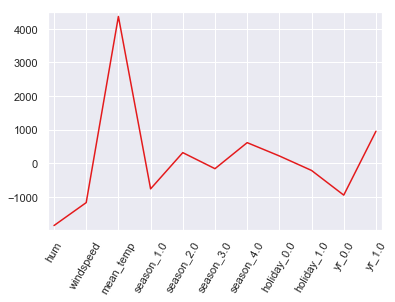

<<<------------------- Training Data Score --------------------->

r square   0.8197797498331456
Adjusted r square:0.8163139757914754
MAPE:18.66229483125625
MSE: 575738.6577453546
RMSE: 758.7744445784627
RMSLE: 0.24072658506194497

<<<------------------- Test Data Score --------------------->

r square   0.5541272773241767
Adjusted r square:0.5177969073283688
MAPE:166.0292261019143
MSE: 1566886.2474201703
RMSE: 1251.7532693866513
RMSLE: 0.5435547344798862


In [444]:
# Instantiate a reg regressor: reg
reg = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the data
reg.fit(train_features,train_target_cnt)

# Compute and print the coefficients
reg_coef = reg.coef_
print(reg_coef)

# Plot the coefficients
plt.plot(range(len(feature.columns)), reg_coef)
plt.xticks(range(len(feature.columns)), feature.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()
test_scores(reg)

In [ ]:
# from regressors import stats
# stats.summary(reg,train_features,train_target_cnt)

Observations: 367
Training Observations: 185
Testing Observations: 182
Observations: 549
Training Observations: 367
Testing Observations: 182
Observations: 731
Training Observations: 549
Testing Observations: 182


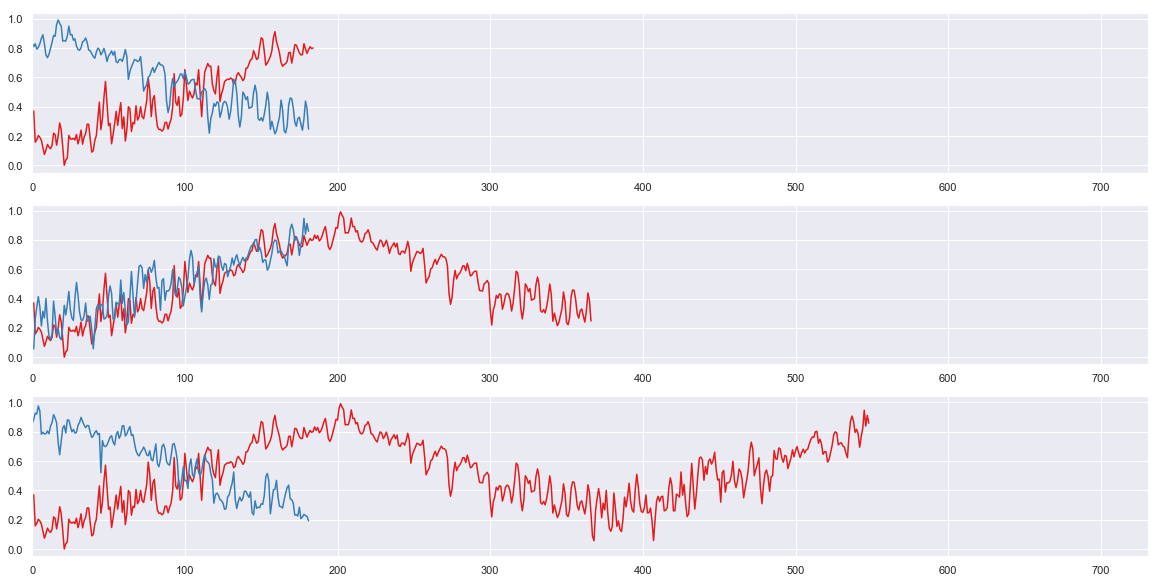

In [401]:
X = feature.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure(figsize=(20,10))
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.xlim(0,731)
    plt.plot(pd.DataFrame(train).iloc[:,2])
    plt.plot(pd.DataFrame(test).iloc[:,2])
    index += 1
plt.show()

## Ridge Regression

In [402]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.10481131341546852, 'max_iter': 500, 'normalize': True}
Best score is 0.3584492123896776


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[-0.18146899 -0.126881    0.40213261 -0.09578498  0.04580561  0.01299345
  0.05807386  0.0228801  -0.0228801  -0.10539124  0.10539124]


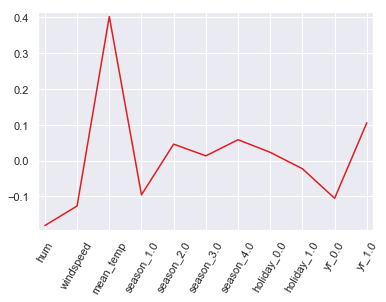

<<<------------------- Training Data Score --------------------->

r square   0.8141105529867916
Adjusted r square:0.8105357559288453
MAPE:19.66492335278352
MSE: 0.00786026345978992
RMSE: 0.08865812686826809
RMSLE: 0.060139149977773955

<<<------------------- Test Data Score --------------------->

r square   0.5171257605894433
Adjusted r square:0.47778045219302756
MAPE:inf
MSE: 0.022460590318763955
RMSE: 0.14986857682237445
RMSLE: 0.09722038275028143


In [403]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.10481131341546852, normalize=True,max_iter = 500)

# Fit the regressor to the data
ridge.fit(train_features,train_target_cnt)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.plot(range(len(feature.columns)), ridge_coef)
plt.xticks(range(len(feature.columns)), feature.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

## Lasso Regression

In [404]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(1000,5000,500)}
# Instantiate a lasso regressor: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.0020235896477251557, 'max_iter': 1000, 'normalize': False}
Best score is 0.3420438938899271


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[-1.44862573e-01 -8.95156467e-02  3.88994306e-01 -1.34032523e-01
  9.54366770e-03 -6.73499375e-03  1.93342910e-02  0.00000000e+00
 -0.00000000e+00 -2.17709207e-01  1.28968373e-16]


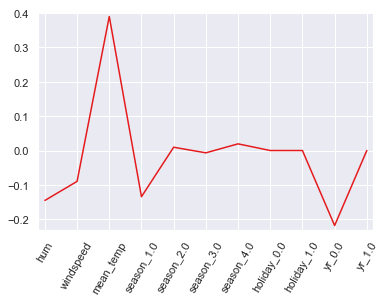

<<<------------------- Training Data Score --------------------->

r square   0.8075995297067204
Adjusted r square:0.8038995206626189
MAPE:20.31181931250526
MSE: 0.008135579564047035
RMSE: 0.0901974476581629
RMSLE: 0.061369187614050566

<<<------------------- Test Data Score --------------------->

r square   0.5117945637132003
Adjusted r square:0.4720148614972388
MAPE:inf
MSE: 0.022708567574896185
RMSE: 0.1506936215468199
RMSLE: 0.09833637735481587


In [405]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.0016768329368110067,max_iter= 1000, normalize=False)

# Fit the regressor to the data
lasso.fit(train_features,train_target_cnt)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(feature.columns)), lasso_coef)
plt.xticks(range(len(feature.columns)), feature.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('lasso coefficients')
plt.show()
test_scores(lasso)

## Decision Tree Regression

In [406]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 4, 'min_samples_split': 6}
Best score is -0.11405498284219874


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.07038998 0.02131261 0.57207224 0.         0.00685796 0.
 0.05407526 0.         0.         0.27529194 0.        ]


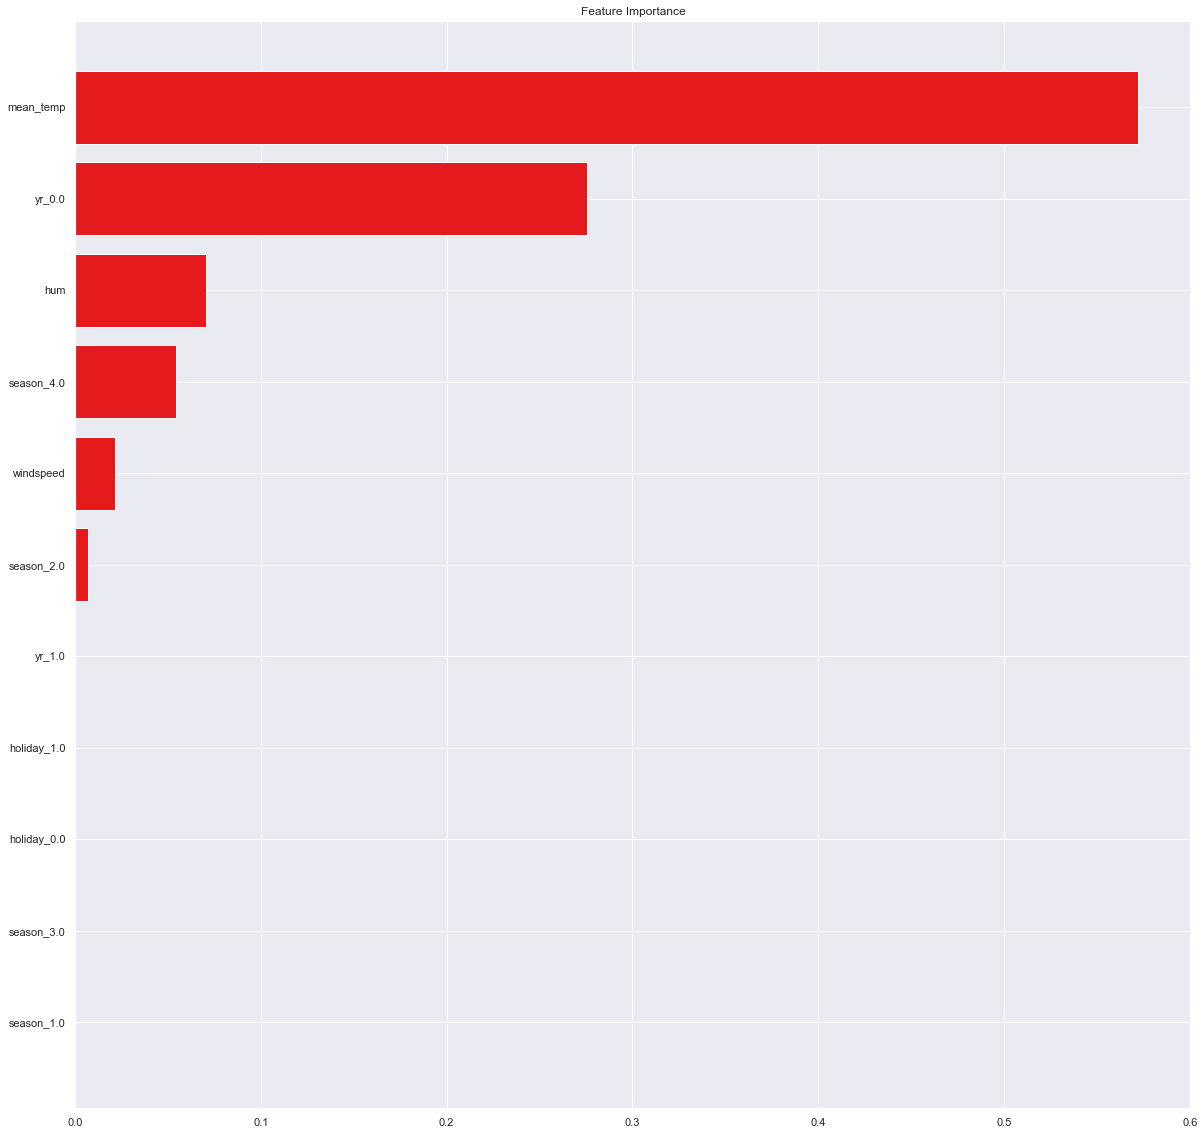

<<<------------------- Training Data Score --------------------->

r square   0.9135779497322527
Adjusted r square:0.9119159872271037
MAPE:11.856532512965943
MSE: 0.003654323011630855
RMSE: 0.06045099677946473
RMSLE: 0.04053607690160492

<<<------------------- Test Data Score --------------------->

r square   0.5199063782226628
Adjusted r square:0.4807876386704354
MAPE:inf
MSE: 0.02233125164547065
RMSE: 0.14943644684437143
RMSLE: 0.09762978763225964


In [407]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=4)

# Fit the regressor to the data
tree.fit(train_features,train_target_cnt)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort feature importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feature.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(train_features).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(train_features).shape[1]), names)
# plt.savefig('tree feature importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Random Forest Regression

In [408]:
# Create the random grid
random_grid = {'n_estimators': range(100,700,100),
               'max_depth': range(10,20,1),
               'min_samples_split':range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = GridSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned Decision Forest Parameters: {'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 100}
Best score is 0.31916492113614514


[0.08787651 0.04172103 0.56655141 0.00965413 0.00544846 0.00071021
 0.03761222 0.00137533 0.00129111 0.12319842 0.12456116]


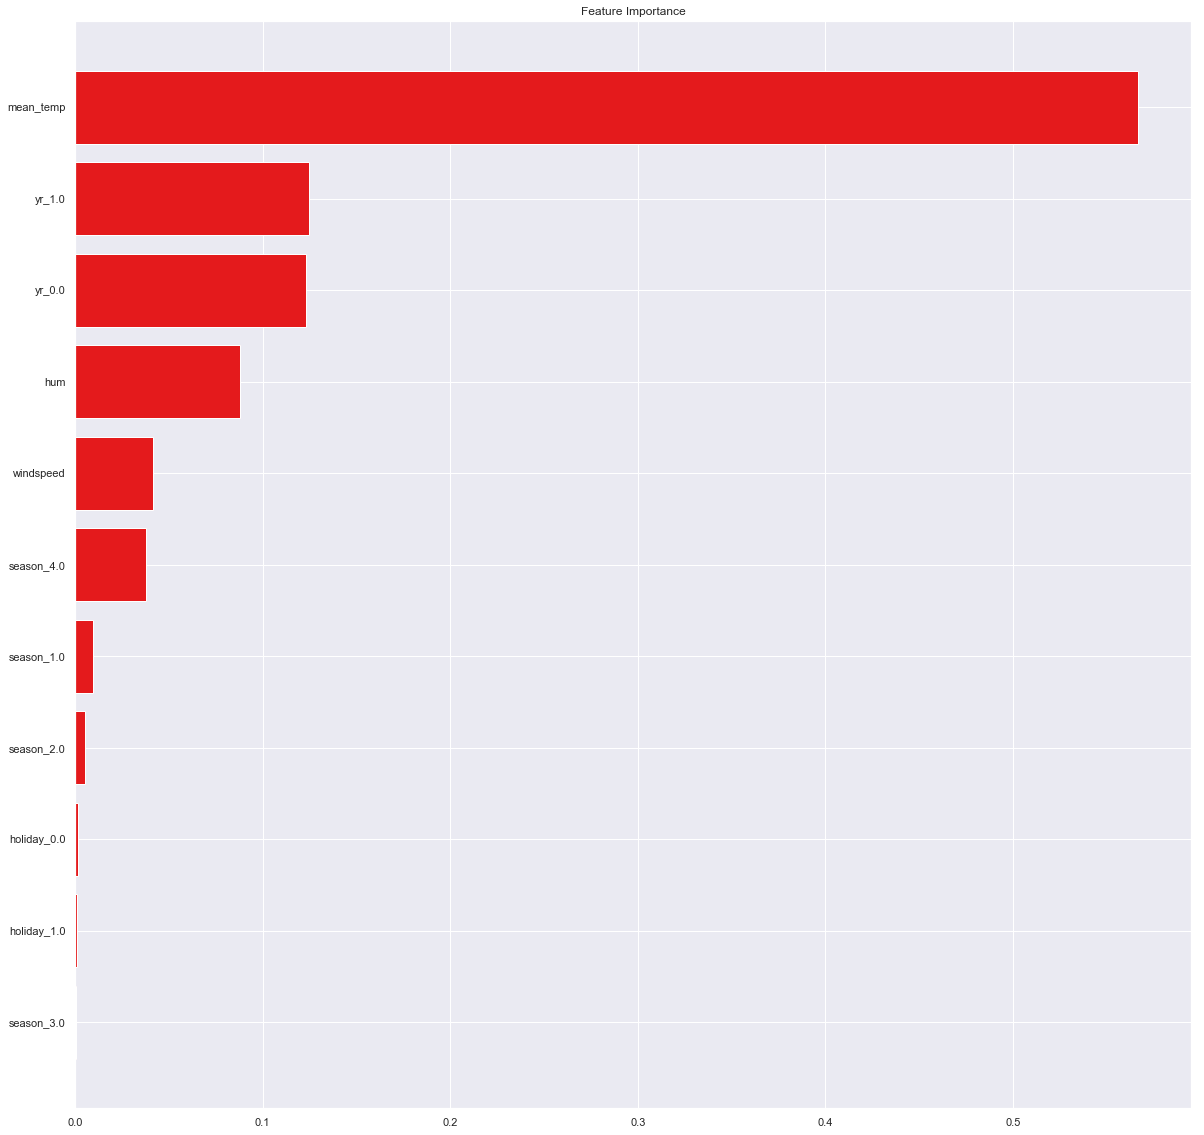

<<<------------------- Training Data Score --------------------->

r square   0.9816912156843978
Adjusted r square:0.9813391236783285
MAPE:6.073032551569959
MSE: 58489.958243065004
RMSE: 241.8469727804444
RMSLE: 0.10264512834910057

<<<------------------- Test Data Score --------------------->

r square   0.5443513186412476
Adjusted r square:0.507224389049053
MAPE:164.89570386028734
MSE: 1601240.9285581019
RMSE: 1265.401489076926
RMSLE: 0.5364369671973868


In [445]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(max_depth= 15, min_samples_split=2,n_estimators=100)

# Fit the regressor to the data
Forest.fit(train_features,train_target_cnt)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feature.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(train_features).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(train_features).shape[1]), names)
# plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

## We have selected Random Forest Regression as our Best Model to Predict Bike Rental Count.

-  Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. 
-  It confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.

- Predicted Bike Rental Count By Random Forest Regression Model Using PCA. 

In [ ]:
test_predicted = Forest.predict(test_features)

In [333]:
pd.DataFrame(test_predicted,index = test_target_cnt.index,columns=['cnt']).head()

cnt
dteday                 
2012-08-07  7301.233364
2012-08-08  7302.736364
2012-08-09  6631.646463
2012-08-10  6170.619286
2012-08-11  6468.002879

- Predicted Bike Rental Count By Random Forest Regression Model without Using PCA. 

In [447]:
pd.DataFrame(test_predicted,index = test_target_cnt.index,columns=['cnt']).head()

cnt
dteday                 
2012-08-07  7164.005139
2012-08-08  7216.232500
2012-08-09  6661.975841
2012-08-10  5995.545167
2012-08-11  6379.173818

- Original Bike Rental Count.

In [448]:
pd.DataFrame(test_target_cnt,columns=['cnt']).head()

cnt
dteday            
2012-08-07  7273.0
2012-08-08  7534.0
2012-08-09  7286.0
2012-08-10  5786.0
2012-08-11  6299.0

-  Line plot of original Vs Predicted Bike Rental count with PCA

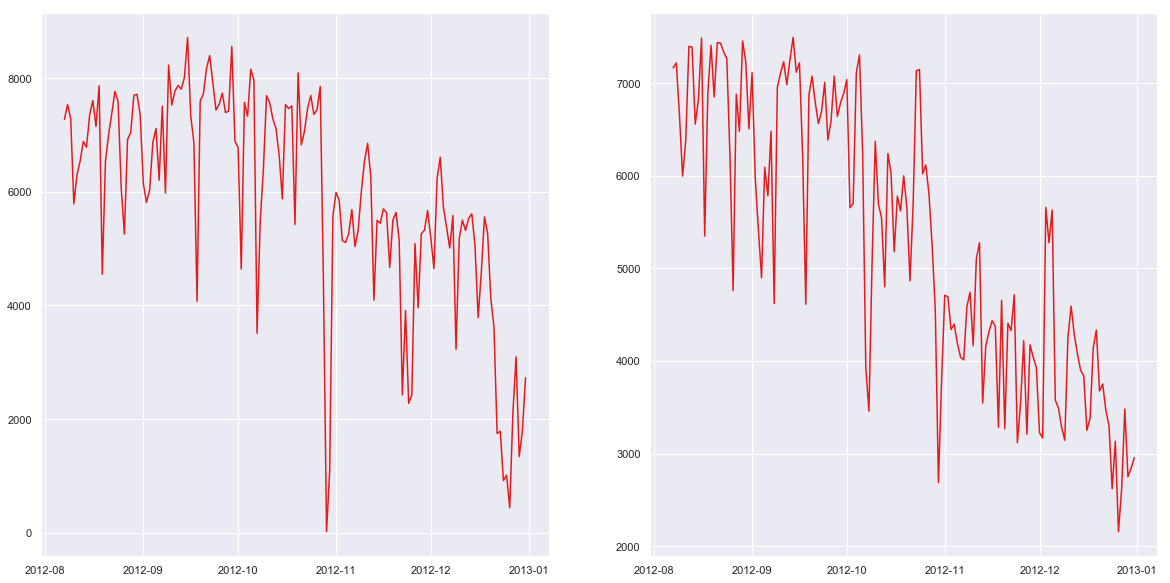

In [446]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(test_target_cnt)
plt.subplot(122)
plt.plot(pd.DataFrame(test_predicted,index = test_target_cnt.index,columns=['cnt']))
# plt.savefig('Line plot of original Vs Predicted Bike Rental count')
plt.show()

-  Line plot of original Vs Predicted Bike Rental count without PCA.

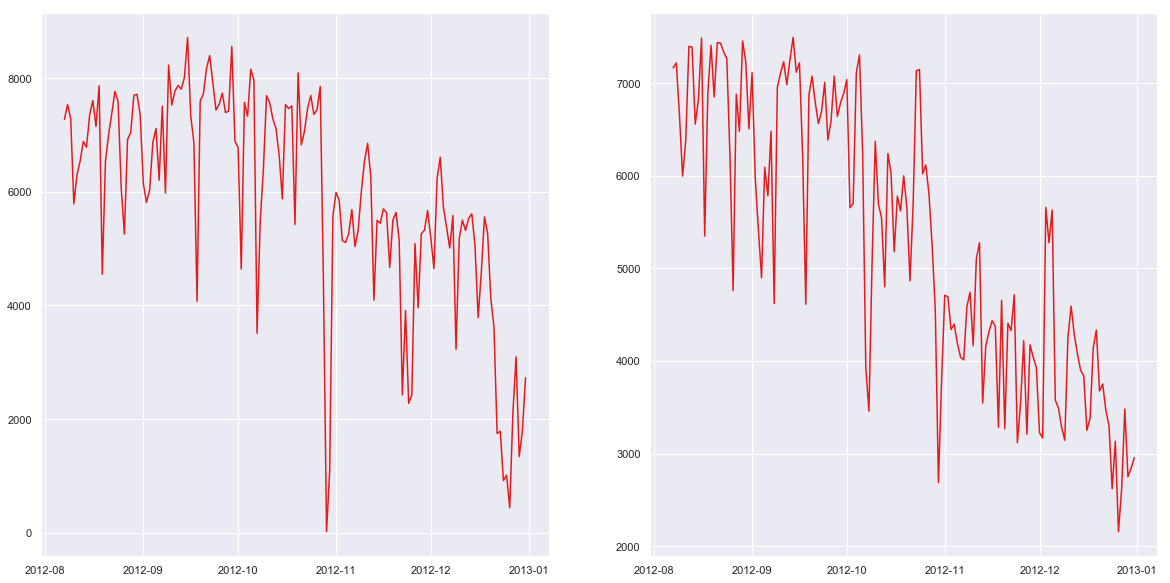

In [449]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(test_target_cnt)
plt.subplot(122)
plt.plot(pd.DataFrame(test_predicted,index = test_target_cnt.index,columns=['cnt']))
# plt.savefig('Line plot of original Vs Predicted Bike Rental count without PCA.')
plt.show()